In [1]:
# Inspiration from https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
# Code from class of Sinan Odzemir on O'Reilly Live Event

In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertModel

import pytorch_lightning as pl
# from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

pl.seed_everything(42)


Global seed set to 42


42

In [3]:
# ingest our data
df = pd.read_csv("../data/toxic.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# 95/5% split
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

## Preprocessing

Let's look at the labels:

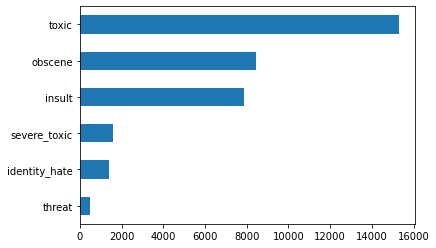

In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

We have a severe case of imbalance. But that is not the full picture. What about the toxic vs clean comments?

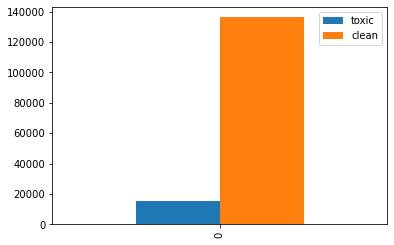

In [6]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='bar');

Again, we have a severe imbalance in favor of the clean comments. To combat this, we'll sample 15,000 examples from the clean comments and create a new training set:

In [7]:
val_toxic = val_df[val_df[LABEL_COLUMNS].sum(axis=1) > 0]
val_clean = val_df[val_df[LABEL_COLUMNS].sum(axis=1) == 0]

In [8]:
train_df = pd.concat([
  train_toxic.sample(500),
  train_clean.sample(500)
])

val_df = pd.concat([
  val_toxic,
  val_clean
]).sample(100)

train_df.shape, val_df.shape

((1000, 8), (100, 8))

### Tokenization


In [9]:
BERT_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [10]:
sample_row = df.iloc[0]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [11]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [12]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [13]:
encoding["input_ids"]

tensor([[  101, 16409,  1643, 20592,  2116,  2009,  1103, 14609,  1116,  1189,
          1223,  1139,  4795, 16124,  9322,  9475,  9953,  9538, 16061,  1127,
         17464,   136,  1220,  3920,   112,   189,  3498,  6919, 16762,   117,
          1198,  8354,  1113,  1199, 20173,  1116,  1170,   146,  4751,  1120,
          1203,  1365, 25137,  1116,  6820,  1658,   119,  1262,  4268,  1274,
           112,   189,  5782,  1103, 27821,  1121,  1103,  2037,  3674,  1290,
           146,   112,   182,  2623,  1208,   119,  5840,   119, 17342,   119,
          3383,   119,  1765,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [14]:
encoding["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [15]:
# The ## represents a subword
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:50])

['[CLS]', 'Ex', '##p', '##lana', '##tion', 'Why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'Hard', '##core', 'Metal', '##lica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'van', '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'GA', '##s', 'after', 'I', 'voted', 'at', 'New', 'York', 'Doll', '##s', 'FA', '##C', '.', 'And', 'please', 'don']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

<AxesSubplot:>

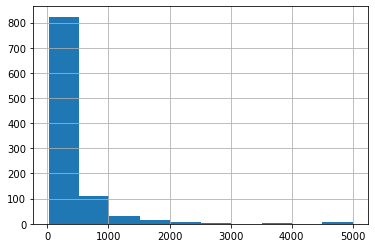

In [16]:
train_df['comment_text'].apply(len).hist()

In [17]:
MAX_TOKEN_COUNT = 512

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [18]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
116801,705d1599cc5caed9,Tvoz's nonsense rvs \nTvoz stop making those c...,1,0,0,0,0,0
94275,fc233d00bee54917,what they speak behind your back when they're ...,1,0,0,0,0,1
149741,60b3ae72a09d568a,Enough crap \nI too have had enough of heavy h...,1,0,0,0,0,0
122803,90e6a4394607bfd2,"You are a dumb flower \n\nNow, normally, I do ...",1,0,0,0,1,0
19326,330c6eca8b91ae37,harass and threaten people,1,0,0,0,0,0


In [19]:
class ToxicCommentsDataset(Dataset):

    def __init__(self, data, tokenizer, max_token_len=MAX_TOKEN_COUNT):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        comment_text = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            comment_text=comment_text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

Let's have a look at a sample item from the dataset:

In [20]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [21]:
sample_item["comment_text"]

"Tvoz's nonsense rvs \nTvoz stop making those changes. It makes sense the way we want it so please stop it. It's annoying"

In [22]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0., 0.])

In [23]:
sample_item["input_ids"].shape

torch.Size([512])

In [24]:
bert_model = DistilBertModel.from_pretrained(BERT_MODEL_NAME)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# A dataloader loads batches of data
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [26]:
N_EPOCHS = 2
BATCH_SIZE = 16

In [27]:
# Our main model class will setup our optimizers, training steps, and loss computationn

class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        # emulates the behavior of BertForSequenceClassification
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        # last hidden state of the CLS token
        output = self.classifier(output.last_hidden_state[:,0,:])
        output = torch.sigmoid(output)    
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        print("train_loss", loss)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        print("val_loss", loss)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):

        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)


    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [28]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [29]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(24, 124)

In [30]:
model = ToxicCommentTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
THRESHOLD = 0.5

test_comment = "You are such an ass! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.detach().flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

severe_toxic: 0.5955775380134583
threat: 0.5741568803787231
insult: 0.5015712976455688
identity_hate: 0.5013079643249512


In [32]:
checkpoint_callback = ModelCheckpoint(
    dirpath="toxic",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [33]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [34]:
trainer = pl.Trainer(
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS
)

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:142: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000001D801312640>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000001D801312640>)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [35]:
val_dataset = ToxicCommentsDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)

In [36]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name       | Type            | Params
-----------------------------------------------
0 | bert       | DistilBertModel | 65.2 M
1 | classifier | Linear          | 4.6 K 
2 | criterion  | BCELoss         | 0     
-----------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.782   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:114: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


val_loss tensor(0.7100)


Global seed set to 42


val_loss tensor(0.7132)


C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:114: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

train_loss tensor(0.7383, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7365, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7433, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7473, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7279, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7368, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7222, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7147, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6990, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7135, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6784, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6742, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6723, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6538, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6414, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6491,

Validating: 0it [00:00, ?it/s]

val_loss tensor(0.0867)
val_loss tensor(0.2169)
val_loss tensor(0.0926)
val_loss tensor(0.1156)
val_loss tensor(0.1123)
val_loss tensor(0.0938)
val_loss tensor(0.2327)
train_loss tensor(0.2629, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2514, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2755, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3526, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3742, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2255, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2937, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1846, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3508, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2388, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2340, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3450, grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2811, grad_fn=<BinaryCrossEntrop

Validating: 0it [00:00, ?it/s]

val_loss tensor(0.0650)
val_loss tensor(0.1928)
val_loss tensor(0.0764)
val_loss tensor(0.1009)
val_loss tensor(0.0903)
val_loss tensor(0.0930)
val_loss tensor(0.1429)


In [71]:
trainer.save_checkpoint("toxic/best-checkpoint.ckpt")

In [72]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  'toxic/best-checkpoint.ckpt',
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
THRESHOLD = 0.5
trained_model = model

test_comment = "You are such an ass! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.detach().flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    if prediction >= THRESHOLD:
        print(f"{label}: {prediction}")

toxic: 0.9354884028434753
obscene: 0.6844916343688965
insult: 0.6336861252784729


## Evaluation

In [74]:
val_data = next(iter(DataLoader(val_dataset, batch_size=16)))
labels = val_data['labels']

_, predictions = trained_model(val_data['input_ids'], val_data['attention_mask'])

In [92]:
from torchmetrics import Accuracy
accuracy = Accuracy(threshold=0.5)

accuracy(predictions, labels.int())

tensor(0.9896)